In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.animation import FuncAnimation

In [2]:
%matplotlib notebook
%config Completer.use_jedi = False

In [3]:
from sis_model import SISModel

In [4]:
def avg_infected_ratio(beta, gamma, p, n, t=100) -> float:
    model = SISModel(nx.generators.erdos_renyi_graph(n, p), beta, gamma)
    sum_of_infected = 0
    for _ in range(t):
        model.next_step()
        sum_of_infected += sum(model.is_infected.values())
    return sum_of_infected / n / t

In [5]:
def avg_infected_ratio_ba(beta, gamma, m, n, t=50) -> float:
    model = SISModel(nx.generators.barabasi_albert_graph(n, m), beta, gamma)
    sum_of_infected = 0
    for _ in range(t):
        model.next_step()
        sum_of_infected += sum(model.is_infected.values())
    return sum_of_infected / n / t

## P11.1
Implement simulation of SIS model on ER graph. Compare
results with our analytical findings. [2P]

In [6]:
n = 300
p = 0.02
beta = 0.15
gamma = 0.35

In [7]:
G = nx.generators.erdos_renyi_graph(n=n, p=p)
sis_model = SISModel(G, beta, gamma)

In [8]:
def init():
    ax.clear()
    sis_model.reset()
    return ax

def update(frame): 
    sis_model.next_step()
    ax.clear()
    ax.set_title(f"Iteration nr. {sis_model.timestep}")
    nx.draw_networkx(sis_model.G,  
                     node_color=[(1, 0.2, 0.2) if sis_model.is_infected[node] else (0.3, 1, 0.2) for node in sis_model.G.nodes()],
                     **graph_args)
    return ax

<IPython.core.display.Javascript object>


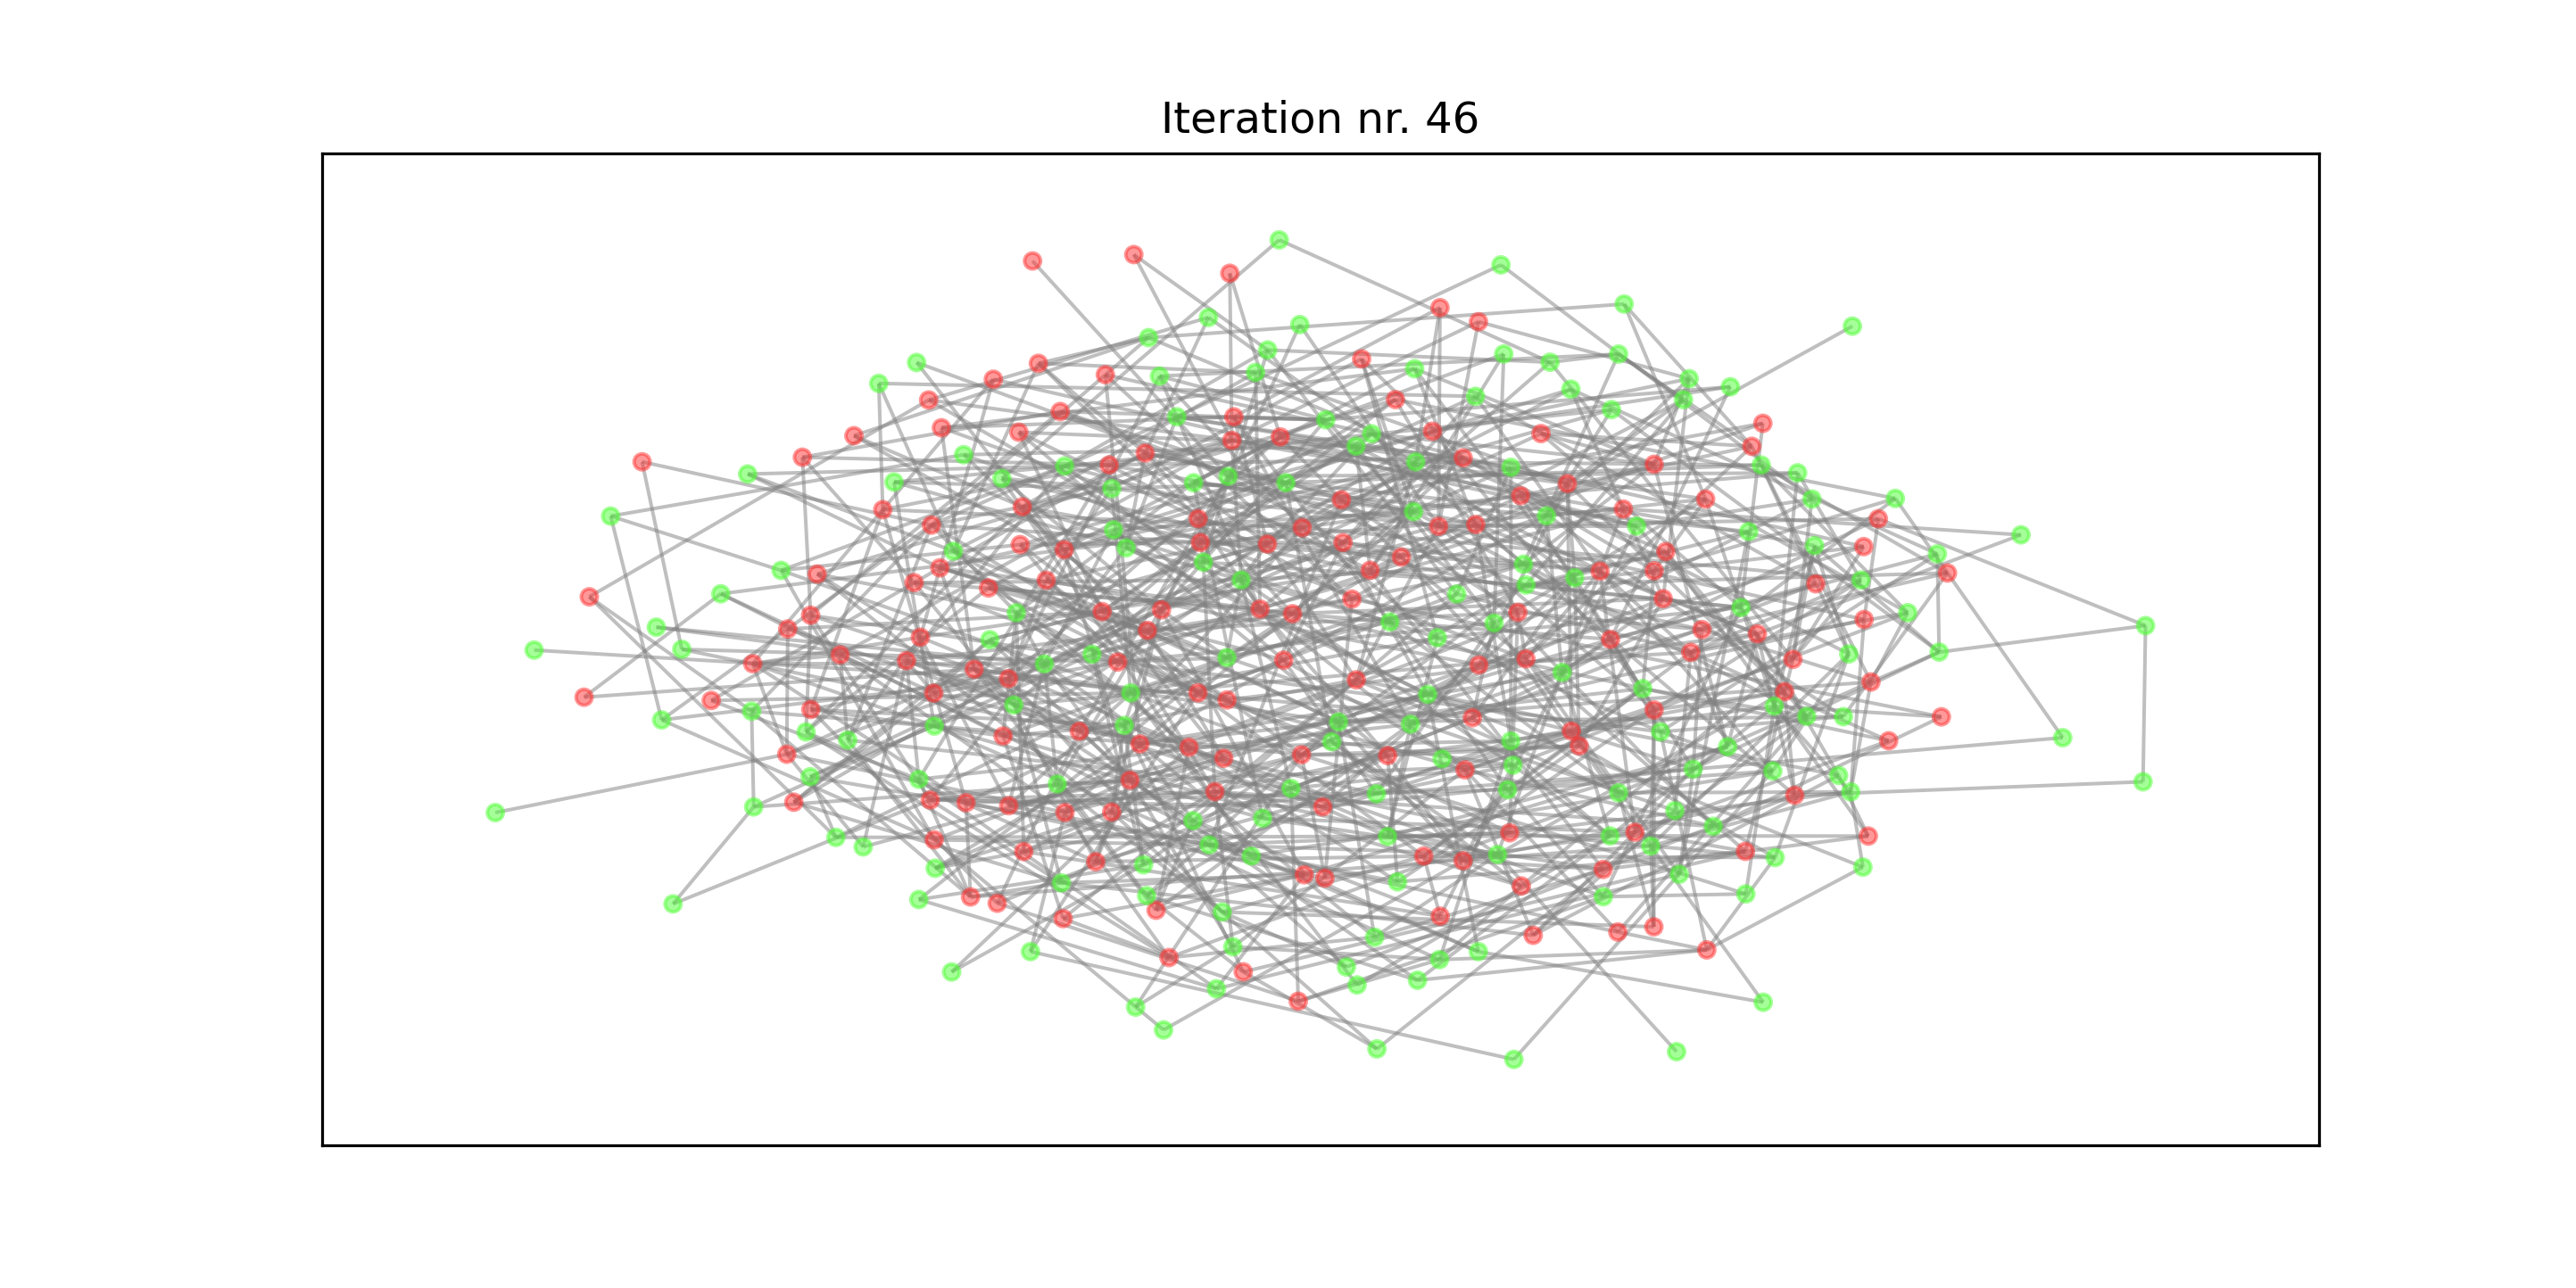

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
pos = nx.kamada_kawai_layout(sis_model.G)
graph_args = {"pos": pos, "ax": ax, "node_size": 20, "with_labels": False, "edge_color": "gray", "alpha": 0.5}

ani = FuncAnimation(fig, update, frames=range(50), interval=500, init_func=init)

### Average Infected Ratio

In [9]:
k = 25
n = 50
p = 0.05
results = pd.DataFrame([
        {
            "beta": beta,
            "gamma": gamma,
            "beta/gamma": beta / gamma,
            "average ratio": avg_infected_ratio(beta, gamma, p, n)
        } for beta in np.log(np.linspace(1.1, 0.9*np.e, k))
          for gamma in np.log(np.linspace(1.1, 0.9*np.e, k))
    ])

results = results.groupby('beta/gamma').mean().reset_index()
results.head(5)

,beta/gamma,beta,gamma,average ratio
0,0.106535,0.09531,0.894639,0.0134
1,0.109371,0.09531,0.871440,0.0116
2,0.112435,0.09531,0.847690,0.0116
3,0.115757,0.09531,0.823362,0.0134
4,0.119372,0.09531,0.798428,0.0134


<IPython.core.display.Javascript object>


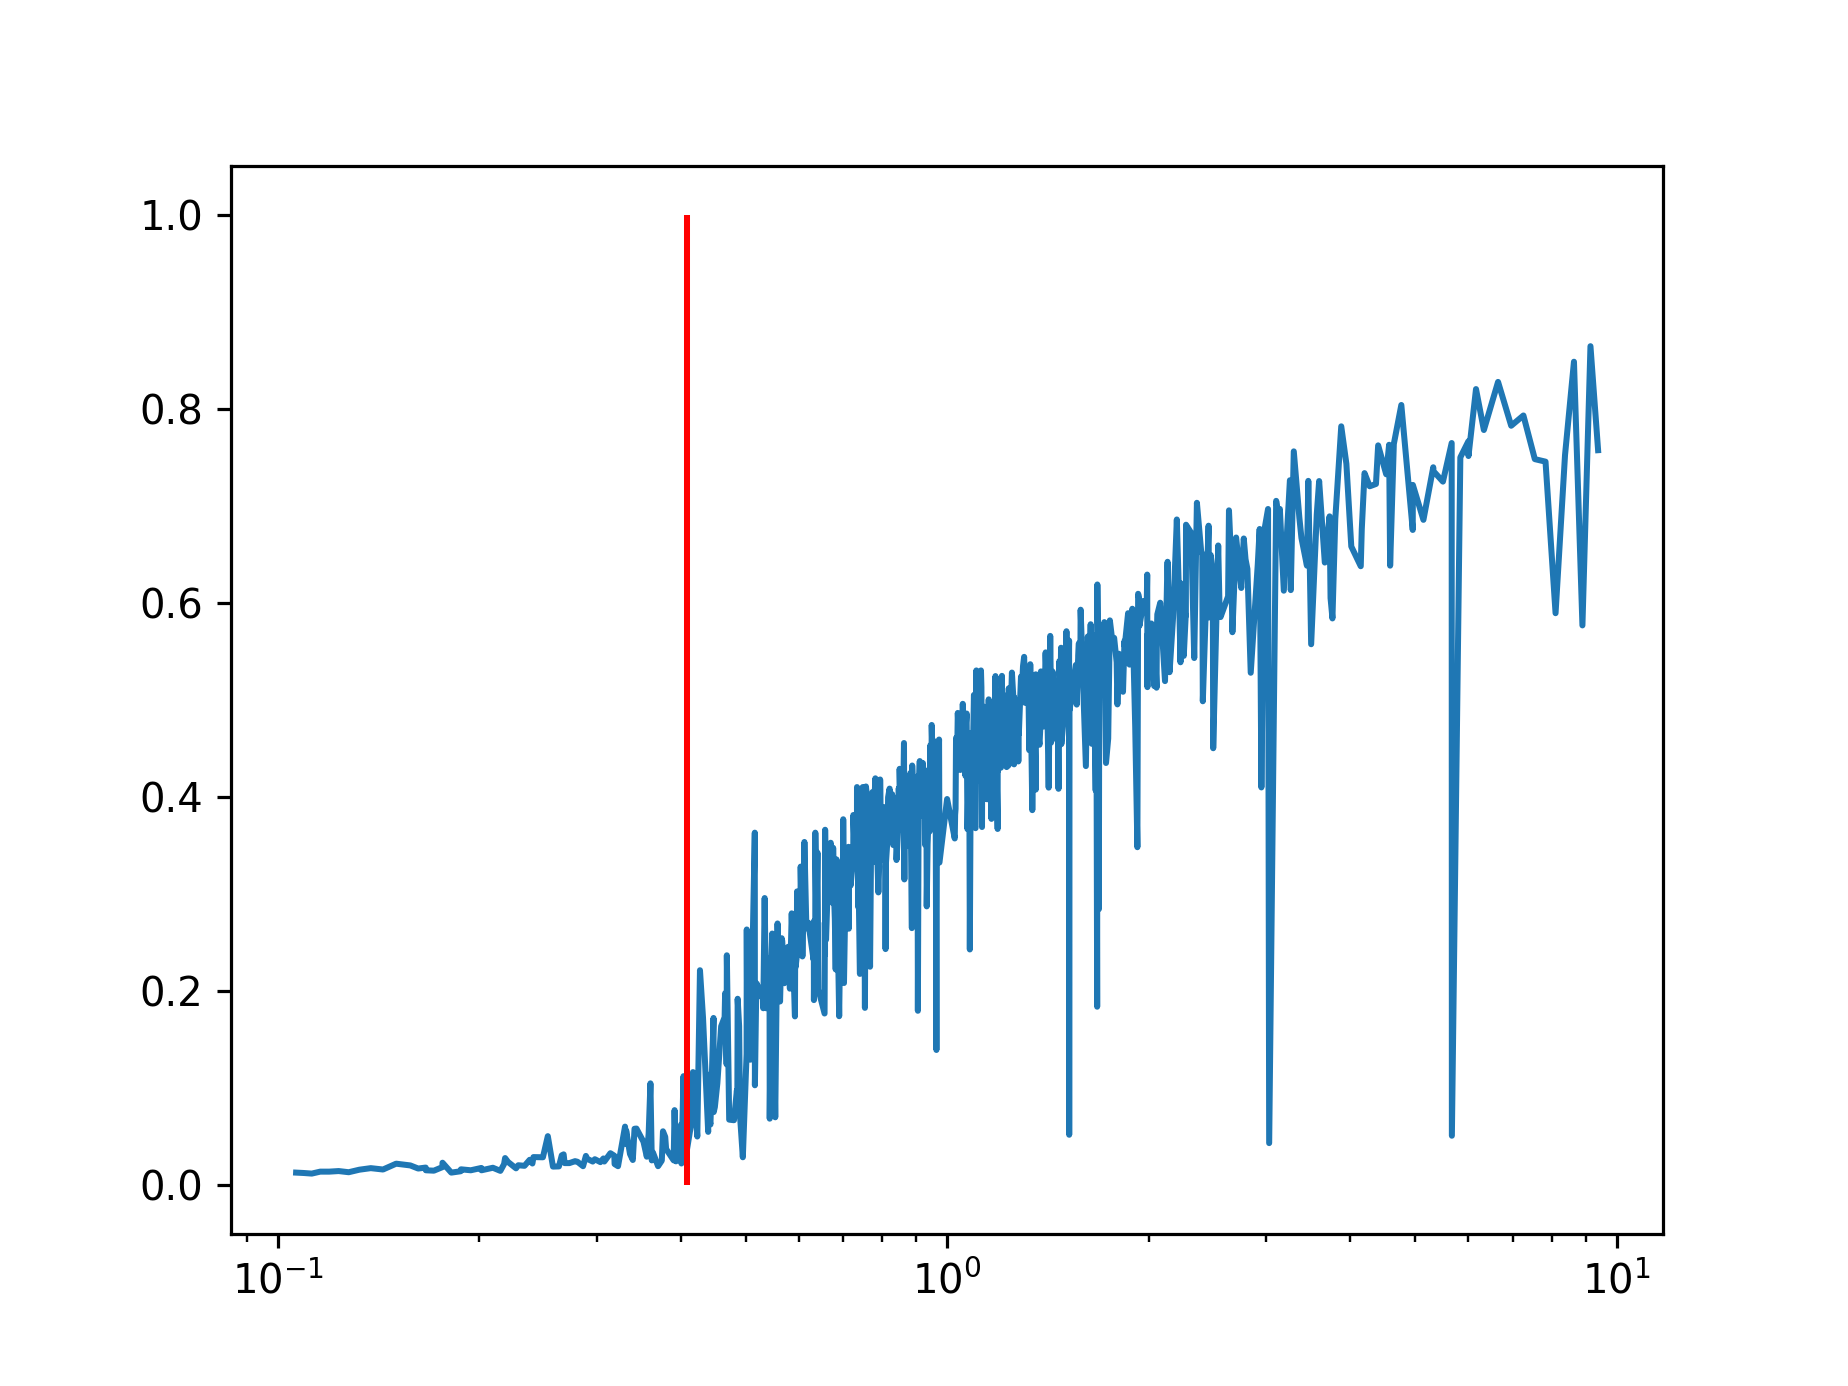

In [10]:
plt.plot(results["beta/gamma"], results["average ratio"])
plt.xscale('log')
# epidemy threshold
threshold = 1 / (p * (n - 1))
plt.vlines(threshold, 0, 1, "red")

## 11.2

Implement simulation of SIS model on BA networks. Compare
results with our analytical findings. [2P]

In [37]:
n = 300
m = 10
G = nx.generators.barabasi_albert_graph(n=100, m=2)
sis_model = SISModel(G, beta=0.2, gamma=0.4)
pos = nx.kamada_kawai_layout(sis_model.G)

In [38]:
def init():
    ax.clear()
    sis_model.reset()
    return ax

def update(frame): 
    sis_model.next_step()
    ax.clear()
    ax.set_title(f"Iteration nr. {sis_model.timestep}")
    nx.draw_networkx(sis_model.G,  
                     node_color=[(1, 0.2, 0.2) if sis_model.is_infected[node] else (0.3, 1, 0.2) for node in sis_model.G.nodes()],
                     **graph_args)
    return ax

<IPython.core.display.Javascript object>


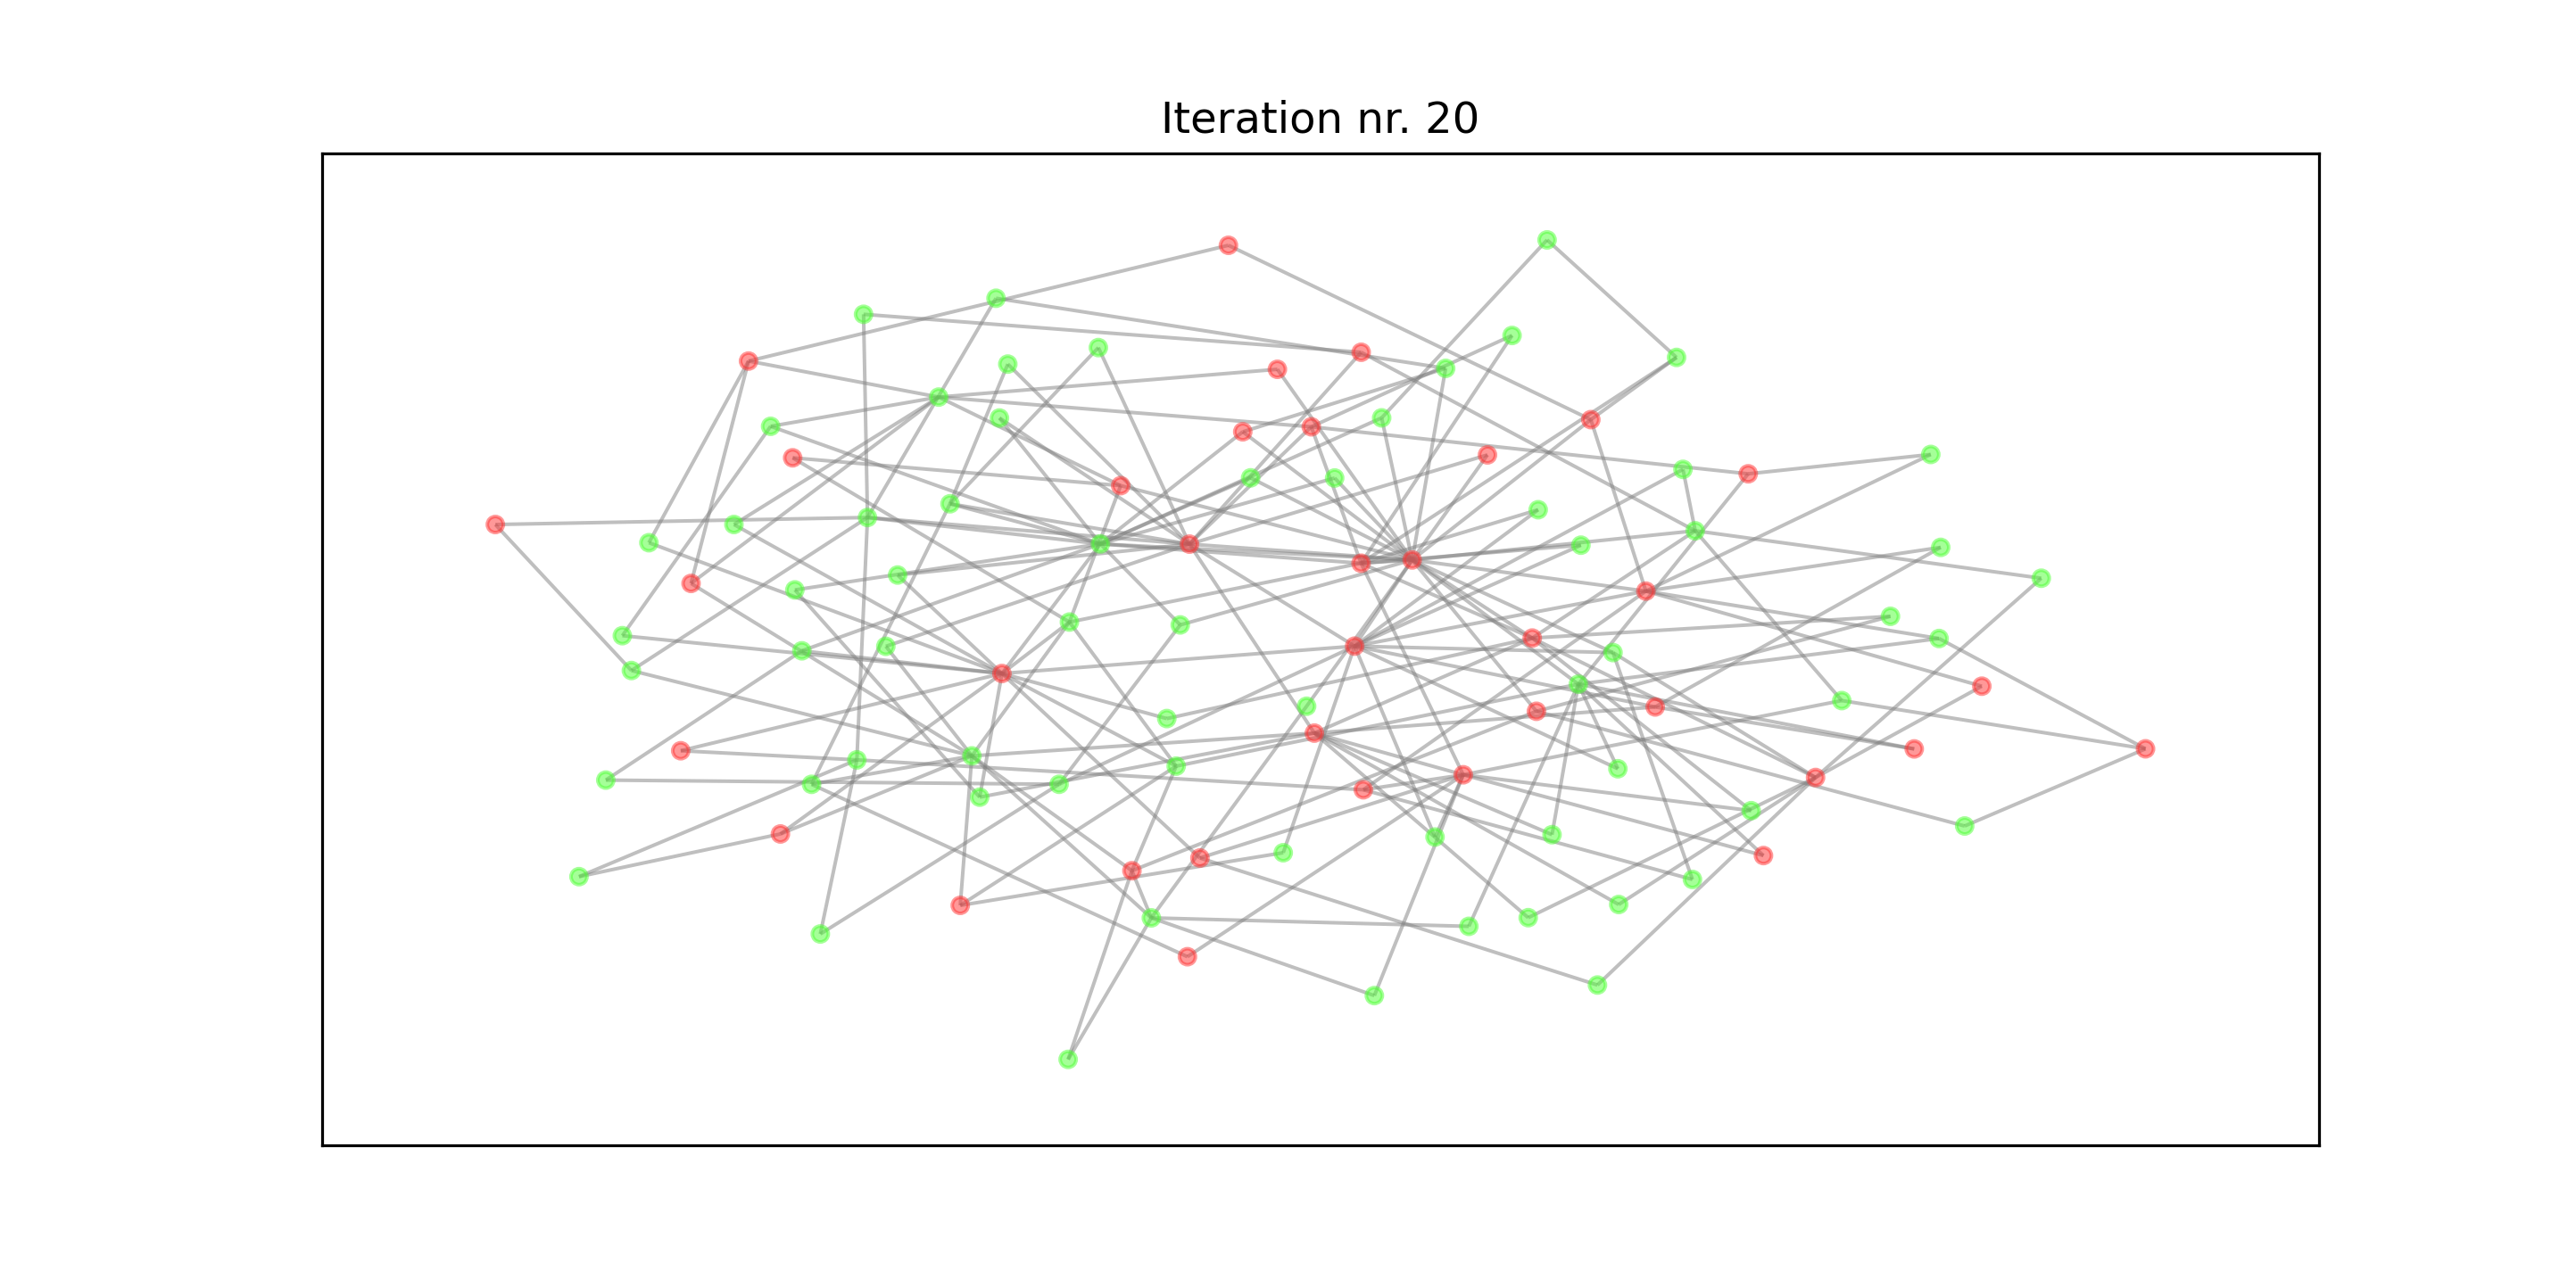

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
graph_args = {"pos": pos, "ax": ax, "node_size": 20, "with_labels": False, "edge_color": "gray", "alpha": 0.5}

ani = FuncAnimation(fig, update, frames=range(50), interval=500, init_func=init)

In [12]:
k = 25
m = 2
n = 50
results = pd.DataFrame([
        {
            "beta": beta,
            "gamma": gamma,
            "beta/gamma": beta / gamma,
            "average ratio": avg_infected_ratio_ba(beta, gamma, m, n)
        } for beta in np.log(np.linspace(1.1, 0.9*np.e, k))
          for gamma in np.log(np.linspace(1.1, 0.9*np.e, k))
    ])

results = results.groupby('beta/gamma').mean().reset_index()
results.head(5)

,beta/gamma,beta,gamma,average ratio
0,0.106535,0.09531,0.894639,0.0132
1,0.109371,0.09531,0.871440,0.0200
2,0.112435,0.09531,0.847690,0.0144
3,0.115757,0.09531,0.823362,0.0148
4,0.119372,0.09531,0.798428,0.0224


<IPython.core.display.Javascript object>


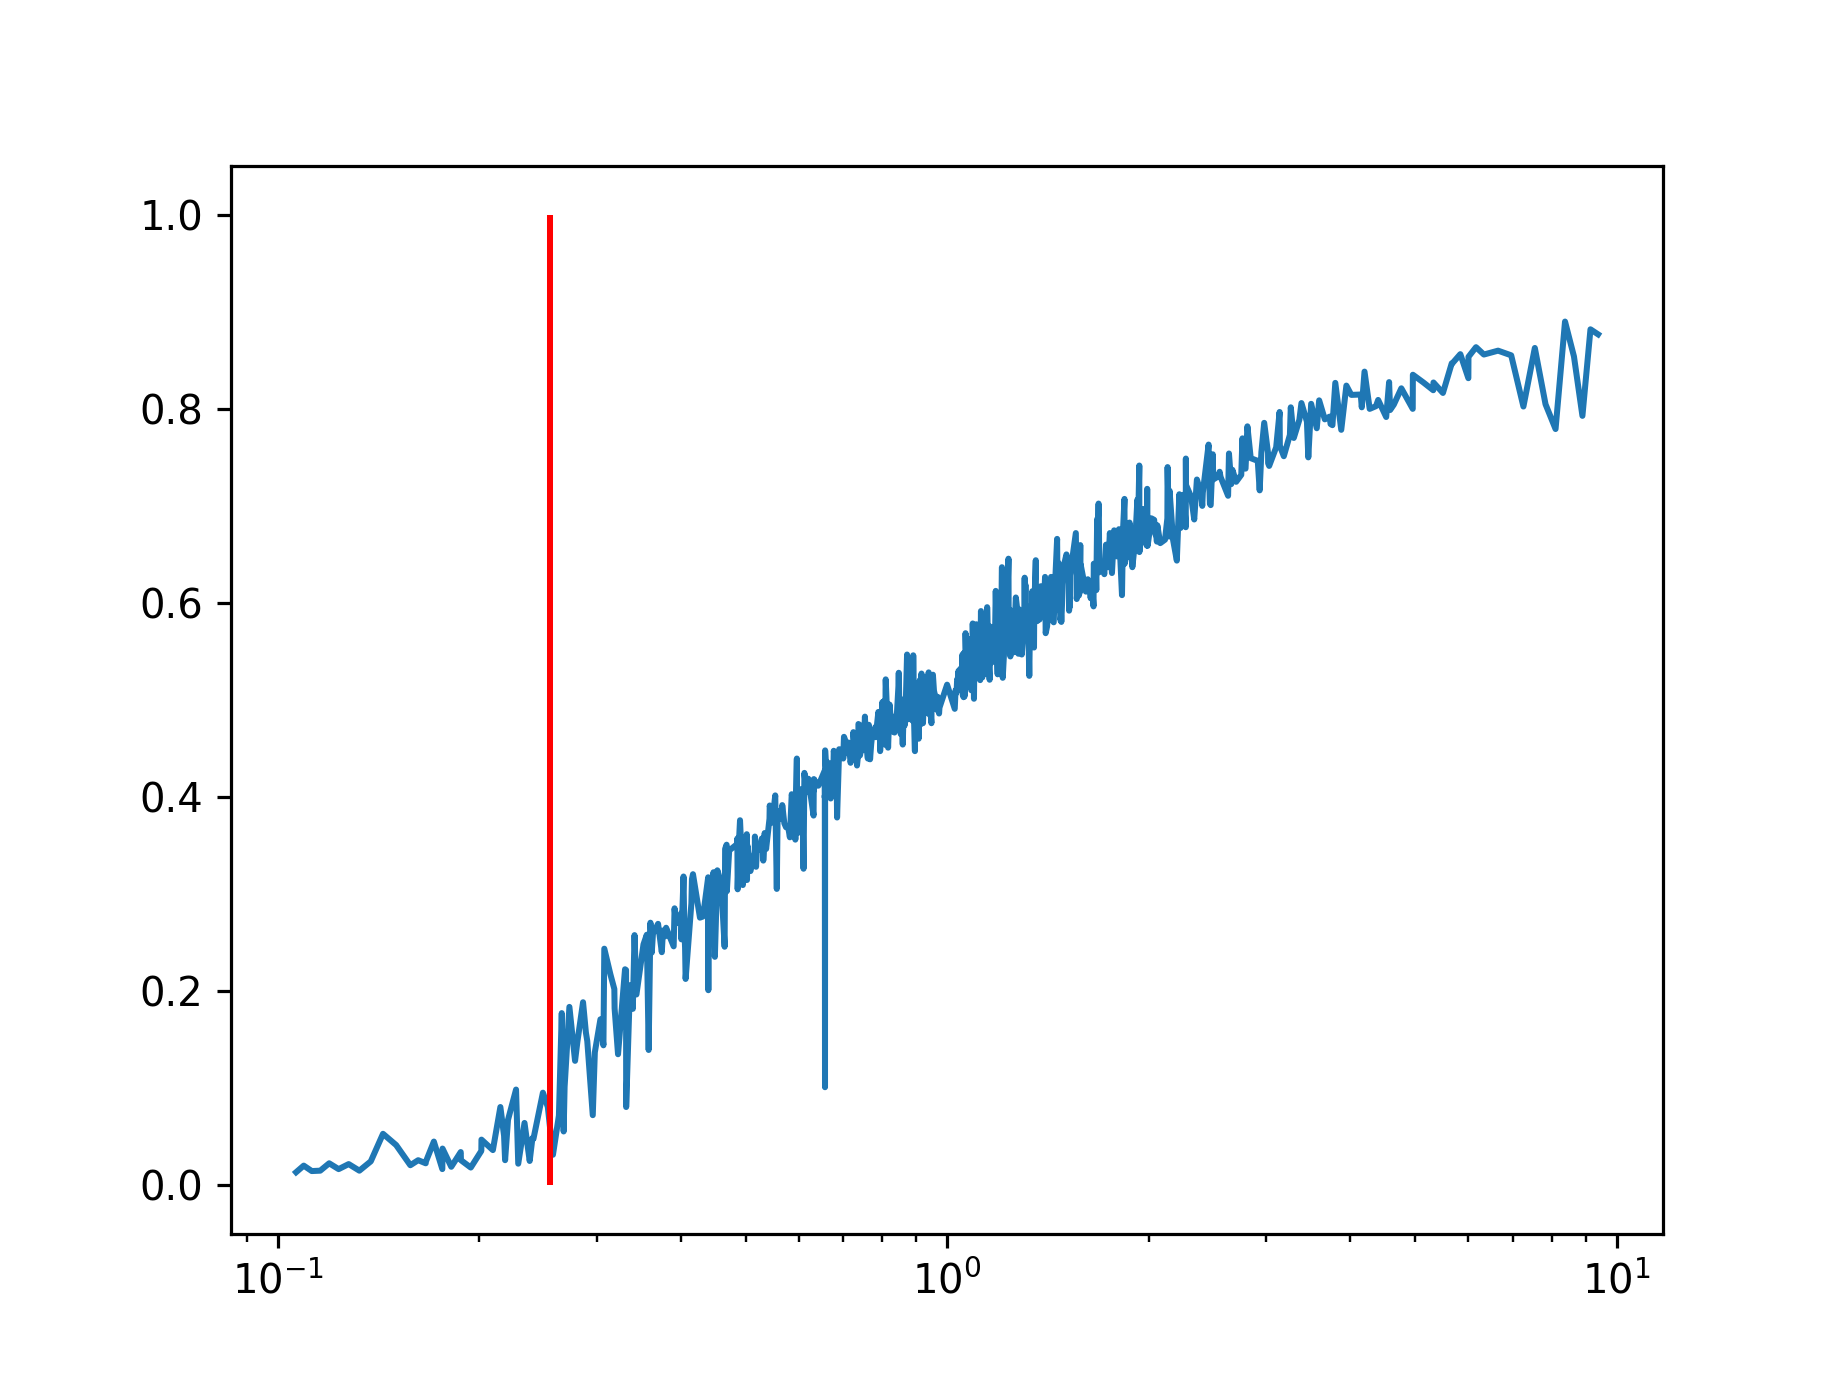

In [13]:
plt.plot(results["beta/gamma"], results["average ratio"])
plt.xscale('log')
# epidemy threshold
threshold = 1 / (2 * m * (n - 1) / n)

plt.vlines(threshold, 0, 1, "red")

## P11.3
Implement simulation of different than SIS agent-based model.
Discuss obtained results. [2P]

The SIR model was introduced in 1927 by Kermack.

In this model, during the course of an epidemics, a node is allowed to change its status from Susceptible (S) to Infected (I), then to Removed (R).

The model is instantiated on a graph having a non-empty set of infected nodes.

SIR assumes that if, during a generic iteration, a susceptible node comes into contact with an infected one, it becomes infected with probability beta, than it can be switch to removed with probability gamma (the only transition allowed are S→I→R).

https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html

In [21]:
# SIR model from NDLib
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

In [22]:
G = nx.generators.barabasi_albert_graph(n=100, m=2)

In [23]:
# Model selection
model = ep.SIRModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.01)
cfg.add_model_parameter('gamma', 0.005)
cfg.add_model_parameter("fraction_infected", 0.01)
model.set_initial_status(cfg)

In [24]:
# Simulation execution
iterations = model.iteration_bunch(200)

In [25]:
iterations

[{'iteration': 0,
  'status': {0: 0,
   1: 0,
   2: 0,
   3: 0,
   4: 0,
   5: 0,
   6: 0,
   7: 0,
   8: 0,
   9: 0,
   10: 0,
   11: 0,
   12: 0,
   13: 0,
   14: 0,
   15: 0,
   16: 0,
   17: 0,
   18: 0,
   19: 0,
   20: 0,
   21: 0,
   22: 0,
   23: 0,
   24: 0,
   25: 0,
   26: 0,
   27: 0,
   28: 0,
   29: 0,
   30: 0,
   31: 0,
   32: 0,
   33: 0,
   34: 0,
   35: 0,
   36: 0,
   37: 0,
   38: 0,
   39: 0,
   40: 0,
   41: 0,
   42: 0,
   43: 0,
   44: 0,
   45: 0,
   46: 0,
   47: 0,
   48: 0,
   49: 0,
   50: 0,
   51: 0,
   52: 0,
   53: 0,
   54: 0,
   55: 0,
   56: 0,
   57: 0,
   58: 0,
   59: 0,
   60: 0,
   61: 0,
   62: 0,
   63: 0,
   64: 0,
   65: 0,
   66: 0,
   67: 0,
   68: 0,
   69: 0,
   70: 0,
   71: 0,
   72: 0,
   73: 0,
   74: 0,
   75: 0,
   76: 0,
   77: 0,
   78: 0,
   79: 0,
   80: 0,
   81: 0,
   82: 0,
   83: 0,
   84: 0,
   85: 0,
   86: 0,
   87: 0,
   88: 0,
   89: 0,
   90: 0,
   91: 0,
   92: 0,
   93: 1,
   94: 0,
   95: 0,
   96: 0,
   97: 0,
  

In [26]:
num_of_infected = [it["node_count"][1] for it in iterations]
np.mean(num_of_infected) / n, 0.01 / 0.005

(0.3005, 2.0)

In [30]:
def avg_infected_ratio_ba_SIR(beta, gamma, m, n, t=100) -> float:
    model = ep.SIRModel(nx.generators.barabasi_albert_graph(n, m))
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter("fraction_infected", 0.01)
    model.set_initial_status(cfg)
    
    iterations = model.iteration_bunch(t)
    
    sum_of_infected = [it["node_count"][1] for it in iterations]
    return np.mean(sum_of_infected) / n

In [31]:
k = 25
m = 2
n = 100
results = pd.DataFrame([
        {
            "beta": beta,
            "gamma": gamma,
            "beta/gamma": beta / gamma,
            "average ratio": avg_infected_ratio_ba_SIR(beta, gamma, m, n)
        } for beta in np.log(np.linspace(1.1, 0.9*np.e, k))
          for gamma in np.log(np.linspace(1.1, 0.9*np.e, k))
    ])

results = results.groupby('beta/gamma').mean().reset_index()
results.head(5)

,beta/gamma,beta,gamma,average ratio
0,0.106535,0.09531,0.894639,0.0001
1,0.109371,0.09531,0.871440,0.0001
2,0.112435,0.09531,0.847690,0.0002
3,0.115757,0.09531,0.823362,0.0010
4,0.119372,0.09531,0.798428,0.0001


<IPython.core.display.Javascript object>


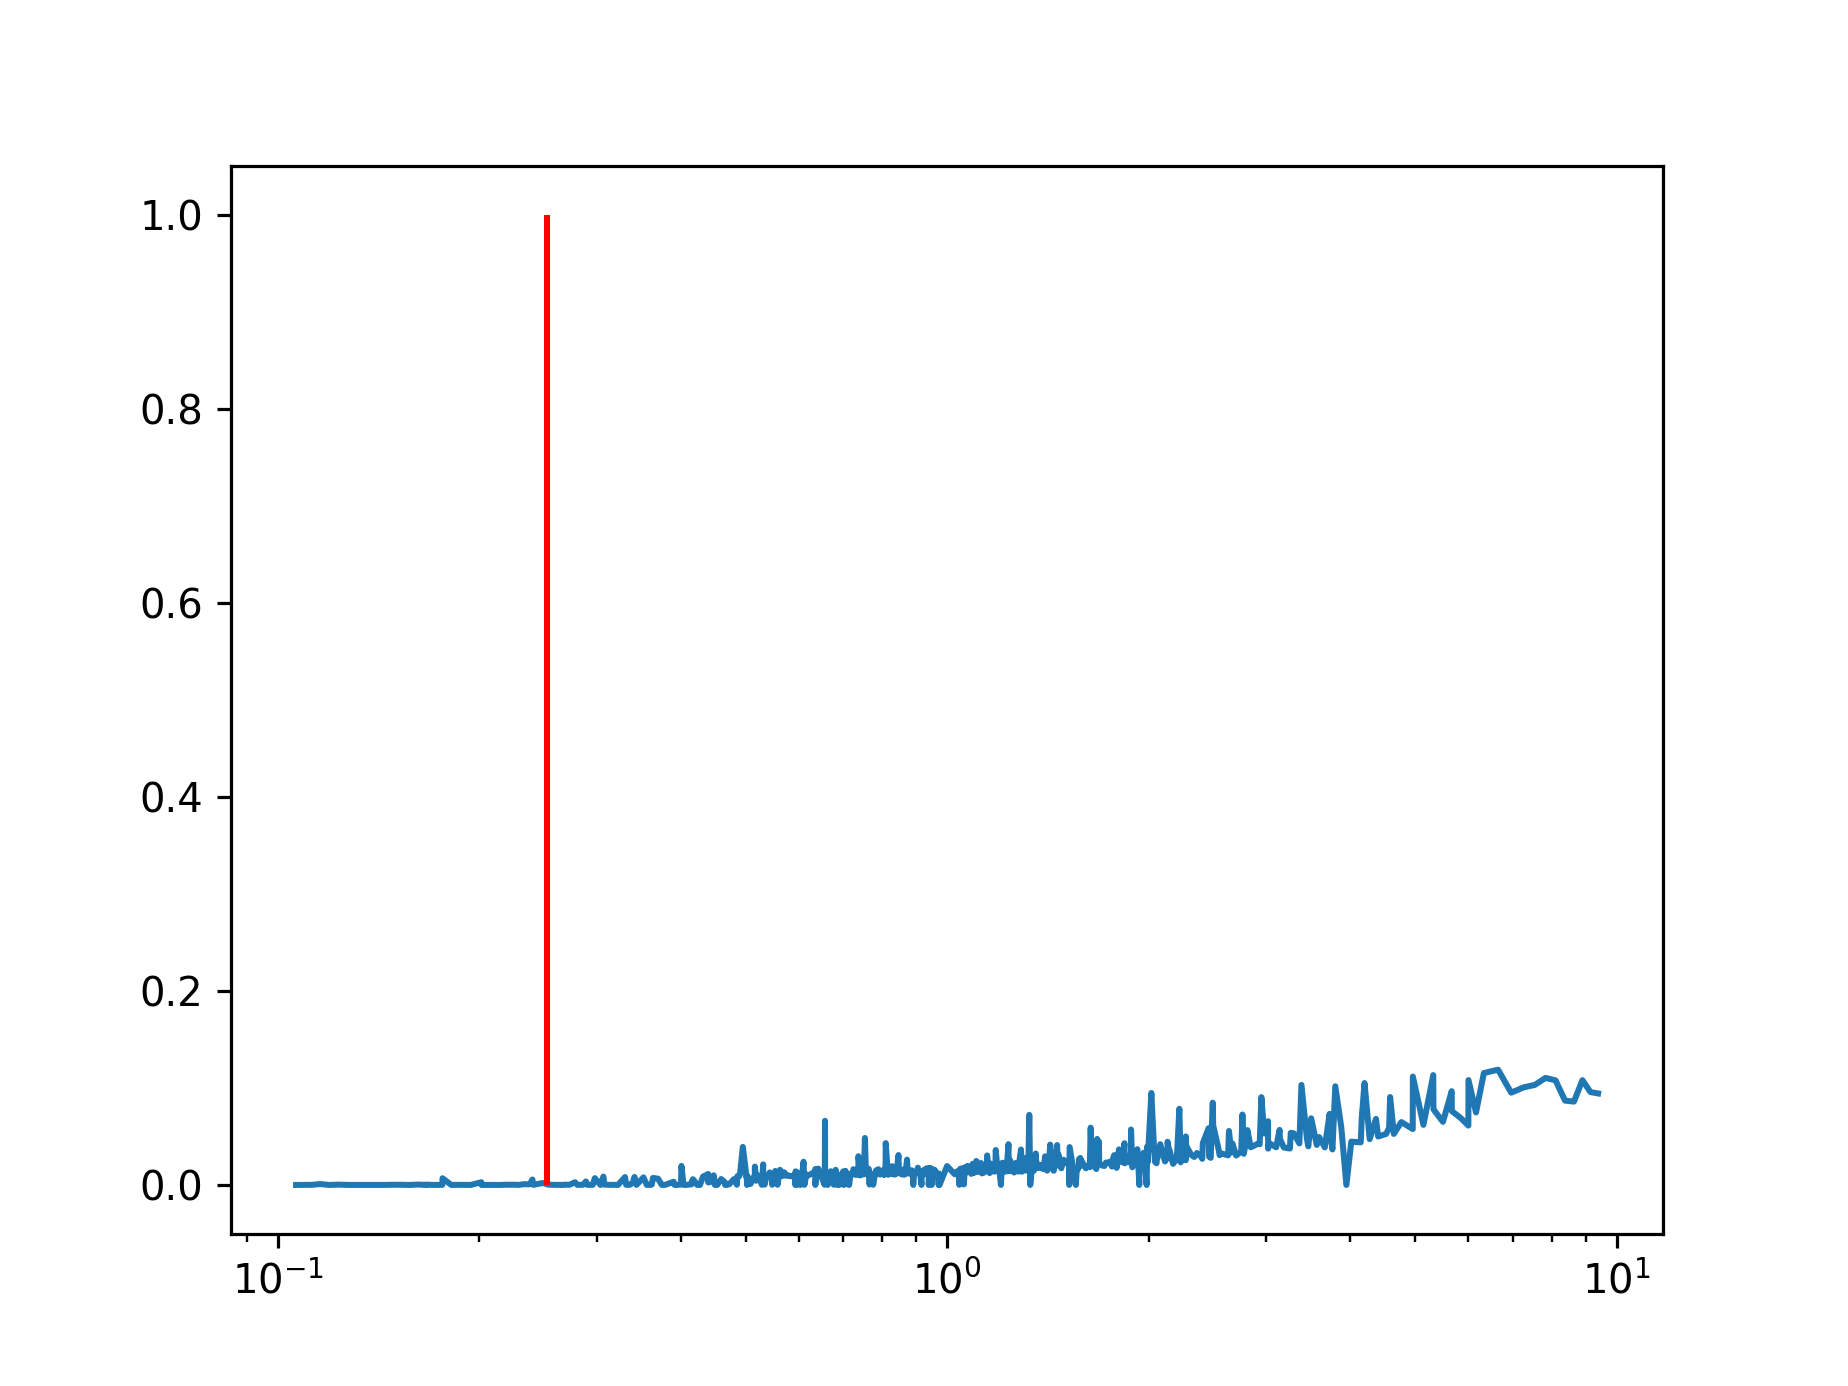

In [34]:
plt.plot(results["beta/gamma"], results["average ratio"])
plt.xscale('log')
# epidemy threshold
threshold = 1 / (2 * m * (n - 1) / n)

plt.vlines(threshold, 0, 1, "red")